In [1]:
import os
from contextlib import redirect_stderr
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import joblib
import numpy as np
from run_experiments import data_base_path, models_path

with redirect_stderr(open(os.devnull, "w")):
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    import tensorflow as tf

# NOTE: Change it according to your setup (if needed)
experiments_path = os.path.join(os.getcwd(), 'experiments')

In [2]:
def get_threshold_at_fpr(labels, scores, max_fpr):
    fpr_list, tpr_list, thresholds = roc_curve(labels, scores, drop_intermediate=True)
    best_tpr = tpr_list[0]
    best_threshold = thresholds[0]

    for fpr, tpr, threshold in zip(fpr_list[1:], tpr_list[1:], thresholds[1:]):
        if fpr <= max_fpr:
            if tpr > best_tpr:
                best_tpr = tpr
                best_threshold = threshold

    return best_threshold

In [3]:
def get_test_data():
    # load data and split test and train data
    json_file = os.path.join(data_base_path, 'preprocessed/normal/deltaphish_total_feature_modified.json')
    with open(json_file) as json_file:
        json_data = json.loads(json_file.read())
        df = pd.json_normalize(json_data)
        data_delta = df.iloc[:,:].astype(float)

    # remove selected phishing samples to eval adversarial robustness, then build training and test sets using remain data
    phish_test = joblib.load(os.path.join(data_base_path, 'preprocessed/phish_sub_test_x_100.pkl'))
    data_delta_new = data_delta.copy()
    data_delta_new = data_delta_new.drop(phish_test.index)

    train, test = train_test_split(data_delta_new, train_size=3200, test_size=700, shuffle=True, random_state=501)
    test_x = test.iloc[:, 0:58]
    test_y = test.iloc[:, 58]
    # only html features
    test_html_x = test.iloc[:, 27:49]

    return test_x, test_html_x, test_y

In [4]:
def plot_sec_eval_curves(max_fpr=0.01, query_limit_plot=None, save_fig=True, num_queries=36, plot_vline=True, plot_manipulations_xaxsis=False, fig_title=None):
    
    models = ['model_cnn_combined', 'model_cnn_html', 'model_rf_combined', 'model_rf_html', 'model_lr_combined', 'model_lr_html']

    test_x, test_html_x, test_y = get_test_data()
    test_x_re = np.asarray(test_x).reshape(test_x.shape[0], test_x.shape[1], 1)
    test_html_x_re = np.asarray(test_html_x).reshape(test_html_x.shape[0], test_html_x.shape[1], 1)

    assert fig_title is None or isinstance(fig_title, str)
    if fig_title is None:
        fig_title = 'sec_eval_curves_{:.1f}fpr.pdf'.format(max_fpr * 100)

    plot_settings_models = {
        'model_cnn_combined': {'color': 'red', 'linestyle': '-'},
        'model_cnn_html': {'color': 'red', 'linestyle': '--'},
        'model_rf_combined': {'color': 'green', 'linestyle': '-'},
        'model_rf_html': {'color': 'green', 'linestyle': '--'},
        'model_lr_combined': {'color': 'blue', 'linestyle': '-'},
        'model_lr_html': {'color': 'blue', 'linestyle': '--'},
    }
    fig_dr, ax_dr = plt.subplots(1, 1)
    num_samples_adv = 100

    for model in models:
        _, ml_algo, feat_type = model.split('_', 3)
        labels = test_y

        if ml_algo == 'cnn':
            test_set = test_x_re if feat_type == 'combined' else test_html_x_re
            ml_model = tf.keras.models.load_model(os.path.join(models_path, model + '.h5'))
            scores = ml_model.predict(test_set)[:, 1]
        else:
            test_set = test_x.values if feat_type == 'combined' else test_html_x.values
            clf_path = os.path.join(models_path, model + '.joblib')
            rfe_path = os.path.join(models_path, model + '_rfe_selector.joblib')
            try:
                ml_model = joblib.load(clf_path)
            except Exception as e:
                raise Exception("Error loading model.")
            try:
                rfe_selector = joblib.load(rfe_path)
            except Exception as e:
                raise Exception("Error loading the RFE selector.")

            test_sel = rfe_selector.transform(test_set)
            scores = ml_model.predict_proba(test_sel)[:, 1]

        threshold = get_threshold_at_fpr(labels, scores, max_fpr)

        results_filepath = os.path.join(experiments_path, 'out_{}/results.json'.format(model))

        col = num_queries + 1
        data_model = np.zeros((num_samples_adv, col))
        with open(results_filepath) as fp:
            idx = 0
            for result in fp.readlines():
                data = json.loads(result)

                scores_trace = eval(data['scores_trace'])
                score_values = []
                manipulations = []

                for query_num, score, manipulation in scores_trace:
                    if not score_values:
                        score_values.append(score)
                    else:
                        if score <= score_values[-1]:
                            score_values.append(score)
                        else:
                            score_values.append(score_values[-1])
                    manipulations.append(manipulation)

                data_model[idx, :] = score_values
                idx += 1

        det_rate_queries = np.mean(data_model > threshold, axis=0) * 100

        if query_limit_plot is not None:
            det_rate_queries = det_rate_queries[:query_limit_plot + 1]

        plot_settings = plot_settings_models[model]

        ax_dr.plot(np.arange(len(det_rate_queries)), det_rate_queries, **plot_settings)

    if plot_vline:
        ax_dr.axvline(11, color='black', ls=':')
    
    ax_dr.set_ylabel('Detection Rate (%)', fontsize=16)  # fontsize=14
    ax_dr.set_ylim(-3, 103)
    ax_dr.yaxis.set_tick_params(labelsize=14)

    if plot_manipulations_xaxsis:
        manipulations[0] = "INIT"
        ax_dr.set_xticks(list(range(0, len(det_rate_queries))), ['{}\n{}'.format(num, man) for num, man in zip(range(0, len(det_rate_queries)), manipulations[:len(det_rate_queries)])])
        fig_dr.set_size_inches(14, 7)
        ax_dr.set_xlabel('Queries and manipulations', fontsize=16)  # fontsize=14
        ax_dr.grid(True)
        ax_dr.xaxis.set_tick_params(labelsize=13)
    else:
        x_values = list(range(0, len(det_rate_queries), 2))
        ax_dr.set_xticks(x_values, [str(x) for x in x_values])
        fig_dr.set_size_inches(10, 5)
        ax_dr.set_xlabel('Num. queries', fontsize=16)
        ax_dr.xaxis.set_tick_params(labelsize=14)

    fig_dr.tight_layout()
    legend_labels = ['$CNN$  $F^c$', '$CNN$  $F^r$', '$RF$  $F^c$', '$RF$  $F^r$', '$LR$  $F^c$', '$LR$  $F^r$']
    fig_dr.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, shadow=True, ncol=len(legend_labels), fontsize=13)
    if save_fig:
        fig_dr.savefig(fig_title, dpi=600, format='pdf', bbox_inches="tight")


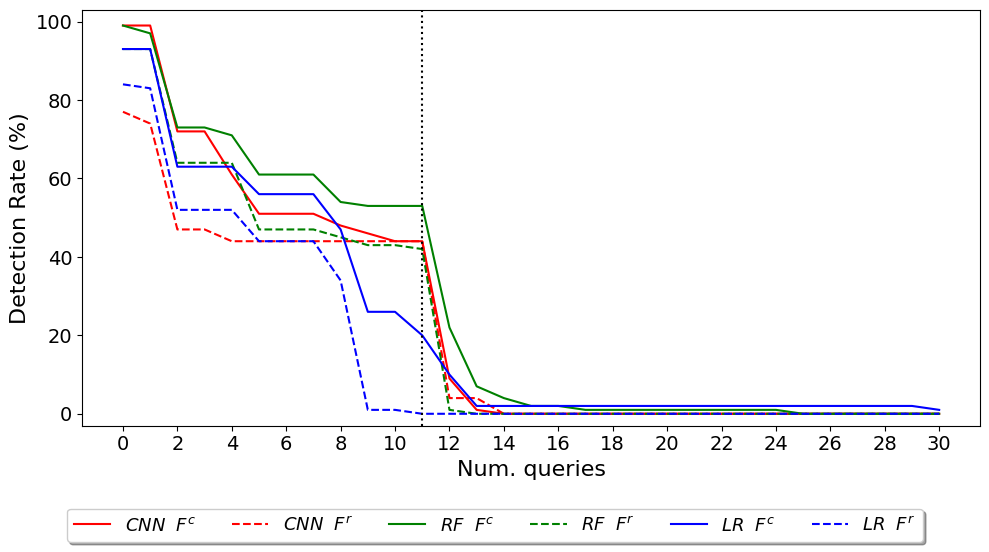

In [5]:
plot_sec_eval_curves(max_fpr=0.01, query_limit_plot=30, save_fig=False, num_queries=36)

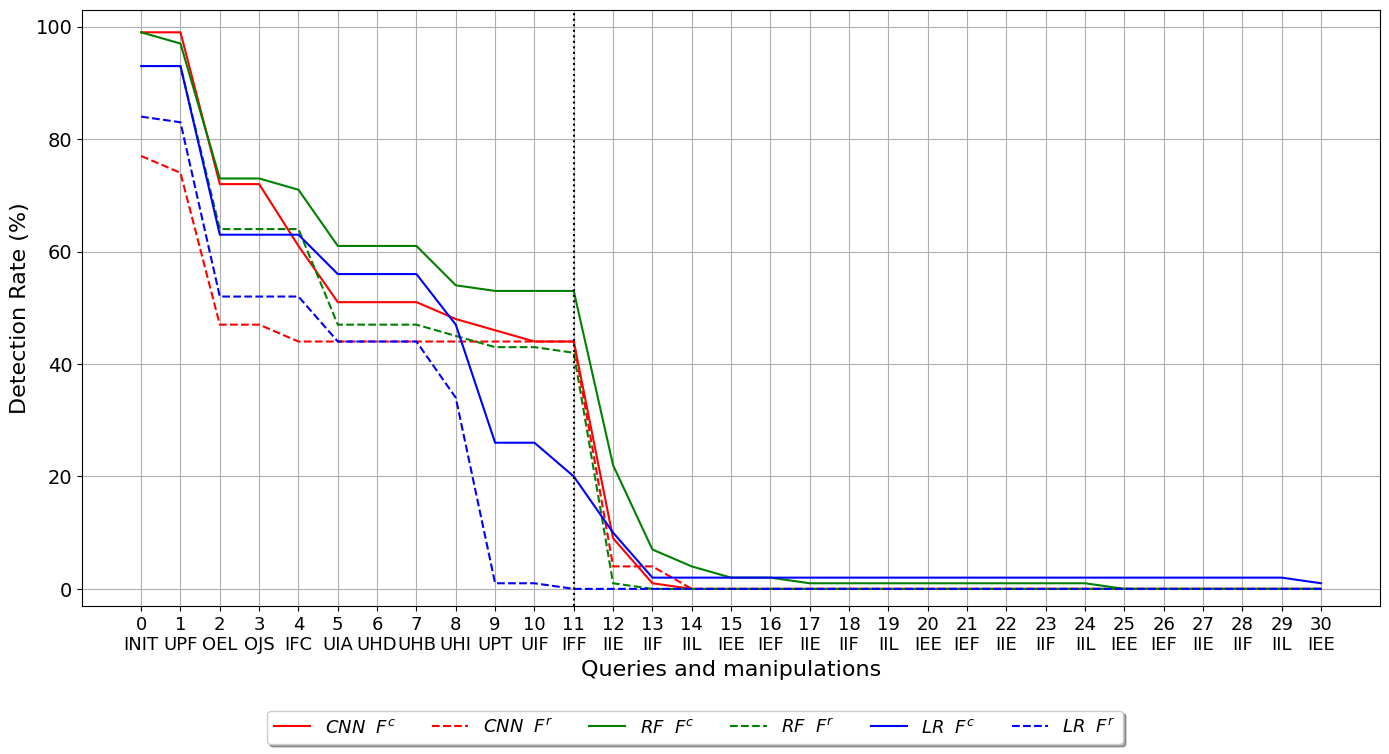

In [6]:
plot_sec_eval_curves(max_fpr=0.01, query_limit_plot=30, save_fig=False, num_queries=36, plot_manipulations_xaxsis=True)